In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


2024-06-27 15:33:29.788905: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 15:33:29.788985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 15:33:29.789023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 15:33:29.798462: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

/tmp/ipykernel_143/2481253413.py:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [9]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

/tmp/ipykernel_143/4217821953.py:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [10]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [11]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [12]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [14]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(4067, 4, 32, 9) (1560, 4, 32, 9)


In [15]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [16]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2024-06-27 15:33:37.742620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:48:00.0, compute capability: 8.0
2024-06-27 15:33:37.744987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 30, 64)      1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               4

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20


2024-06-27 15:33:41.088755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-27 15:33:42.126890: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a8f1e2beb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-27 15:33:42.126938: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-06-27 15:33:42.126944: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-06-27 15:33:42.132968: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-27 15:33:42.221500: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 4s 27ms/step - loss: 0.3677 - accuracy: 0.8547 - val_loss: 0.2178 - val_accuracy: 0.8878
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2230 - accuracy: 0.9063 - val_loss: 0.2101 - val_accuracy: 0.8935
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2126 - accuracy: 0.9115 - val_loss: 0.2010 - val_accuracy: 0.9189
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2019 - accuracy: 0.9142 - val_loss: 0.1967 - val_accuracy: 0.9214
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1955 - accuracy: 0.9147 - val_loss: 0.1947 - val_accuracy: 0.9132
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1853 - accuracy: 0.9201 - val_loss: 0.1971 - val_accuracy: 0.9214
Epoch 7/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1860 - accuracy: 0.9184 - val_loss: 0.1935 - val_accuracy: 0.9050
Epoch 8/20
32/32 [============

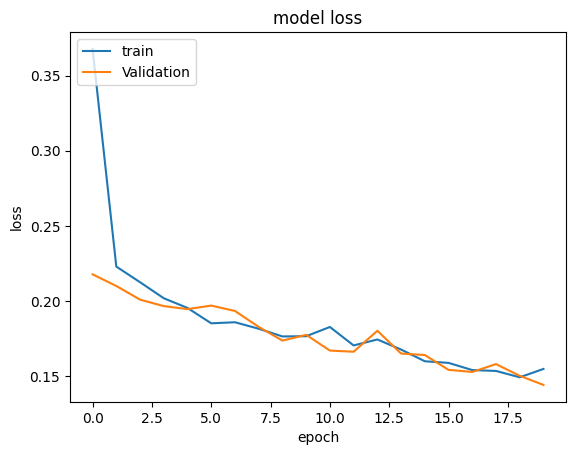

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

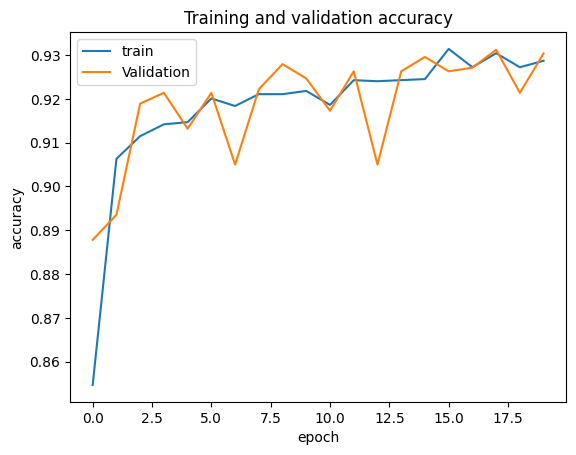

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
0.8705128205128205
0.8718917704421234


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

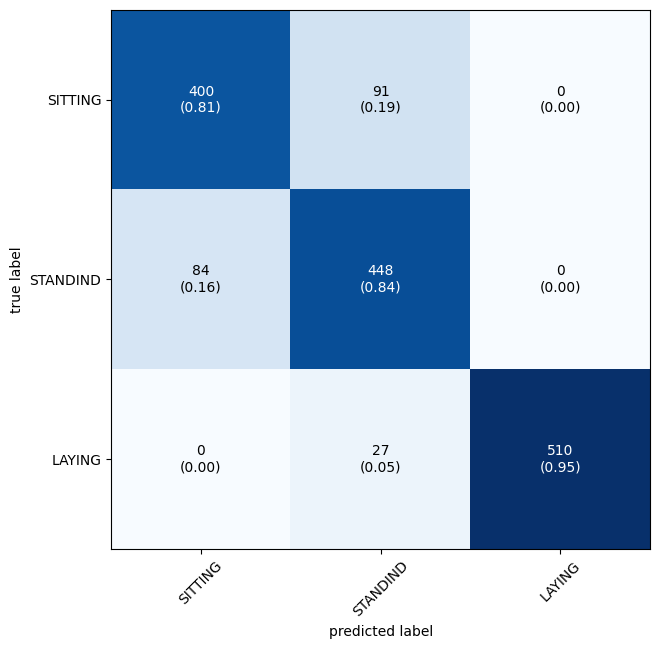

In [20]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# Layer 3

# CNN 3

In [21]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

# Global Average Pooling to remove the time dimension and keep only features dimension
model.add(GlobalAveragePooling1D())

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 28, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 28, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 14, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, None, 12, 64)     

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 2s 18ms/step - loss: 0.3769 - accuracy: 0.8399 - val_loss: 0.2503 - val_accuracy: 0.9140
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2150 - accuracy: 0.9120 - val_loss: 0.2601 - val_accuracy: 0.9148
Epoch 3/20
32/32 [==============================] - 0s 8ms/step - loss: 0.2035 - accuracy: 0.9110 - val_loss: 0.2728 - val_accuracy: 0.9025
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1920 - accuracy: 0.9181 - val_loss: 0.2529 - val_accuracy: 0.9115
Epoch 5/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1961 - accuracy: 0.9130 - val_loss: 0.2593 - val_accuracy: 0.9206
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1864 - accuracy: 0.9194 - val_loss: 0.2513 - val_accuracy: 0.9189
Epoch 7/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1858 - accuracy: 0.9198 - val_loss: 0.2624 - val_accuracy: 0.9091
Epoch 8/20
32/32 [=

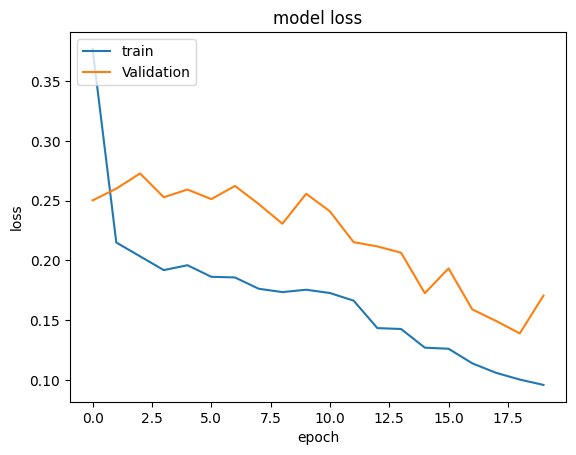

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

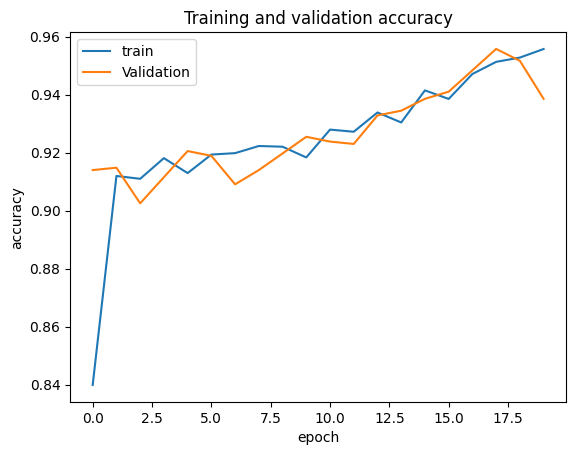

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
0.8705128205128205
0.869802538124601


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

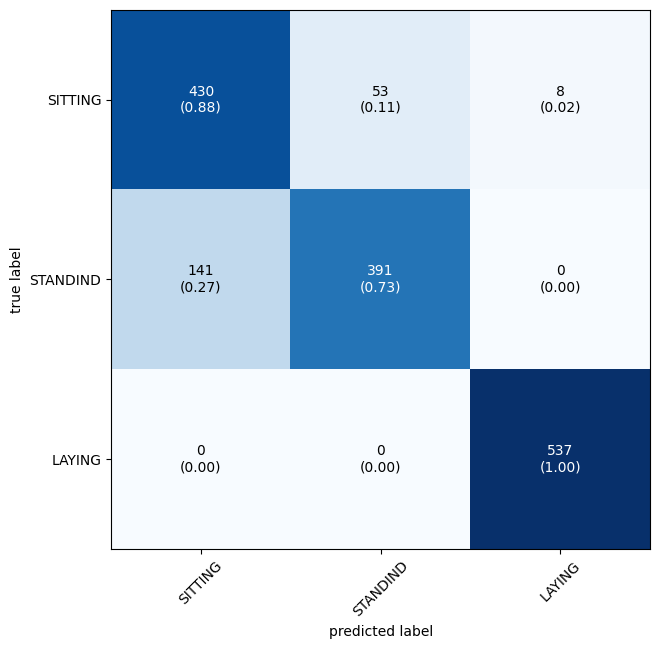

In [25]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN 1 - LSTM2



In [26]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)        

In [27]:

# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 4s 38ms/step - loss: 0.4273 - accuracy: 0.8306 - val_loss: 0.2364 - val_accuracy: 0.9099
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2222 - accuracy: 0.9088 - val_loss: 0.2176 - val_accuracy: 0.8903
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2064 - accuracy: 0.9103 - val_loss: 0.1979 - val_accuracy: 0.9271
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.2073 - accuracy: 0.9095 - val_loss: 0.1901 - val_accuracy: 0.9197
Epoch 5/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1890 - accuracy: 0.9203 - val_loss: 0.1940 - val_accuracy: 0.9050
Epoch 6/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1896 - accuracy: 0.9186 - val_loss: 0.1811 - val_accuracy: 0.9255
Epoch 7/20
32/32 [==============================] - 0s 9ms/step - loss: 0.1886 - accuracy: 0.9213 - val_loss: 0.1820 - val_accuracy: 0.9230
Epoch 8/20
32/32 [=

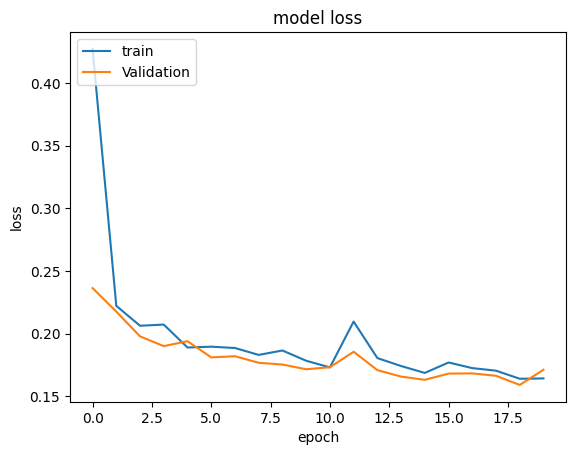

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

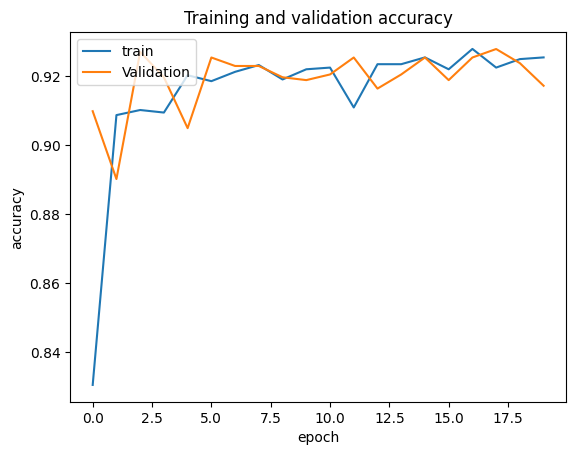

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 2ms/step
0.8666666666666667
0.8677691773559099


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

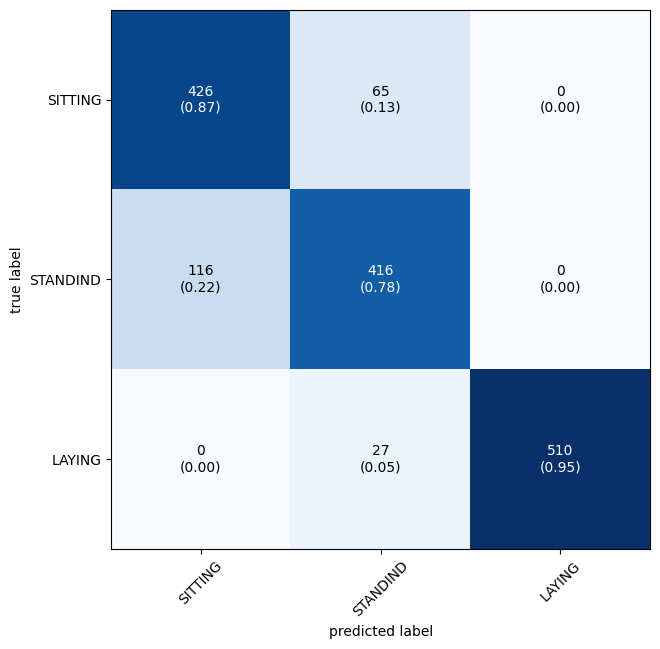

In [30]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN2 - LSTM1

In [31]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, None, 896)        

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 3s 18ms/step - loss: 0.3642 - accuracy: 0.8557 - val_loss: 0.2168 - val_accuracy: 0.9197
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2194 - accuracy: 0.9100 - val_loss: 0.2048 - val_accuracy: 0.9222
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2012 - accuracy: 0.9149 - val_loss: 0.2091 - val_accuracy: 0.9238
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2010 - accuracy: 0.9110 - val_loss: 0.1968 - val_accuracy: 0.9279
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1871 - accuracy: 0.9191 - val_loss: 0.1846 - val_accuracy: 0.9255
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1833 - accuracy: 0.9179 - val_loss: 0.1779 - val_accuracy: 0.9222
Epoch 7/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1788 - accuracy: 0.9225 - val_loss: 0.1825 - val_accuracy: 0.9165
Epoch 8/20
32/32 [=

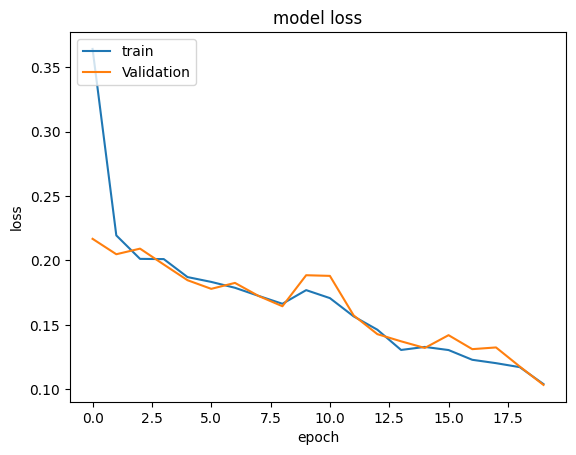

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

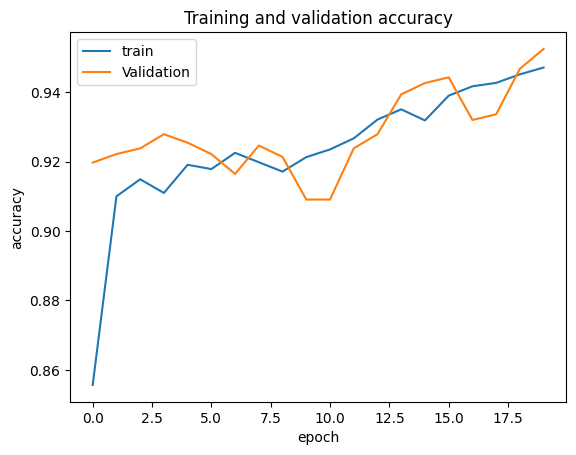

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
0.8884615384615384
0.8893567386042681


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

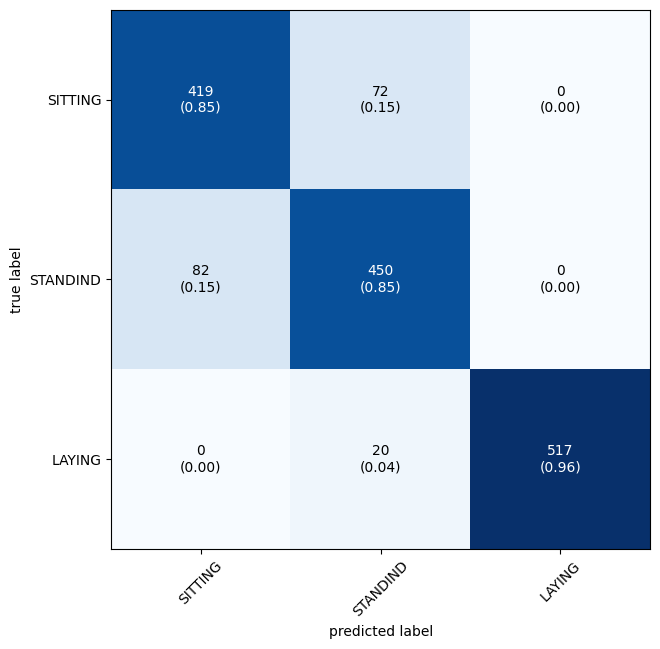

In [35]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

#  LSTM3

In [36]:
# define model
model = Sequential()
model.add(TimeDistributed(LSTM(100, return_sequences=True), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100)))

# Use TimeDistributed to flatten the LSTM outputs
model.add(TimeDistributed(Flatten()))

# Pool the time dimension
model.add(GlobalAveragePooling1D())

# Adding Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeD  (None, None, 32, 100)     44000     
 istributed)                                                     
                                                                 
 time_distributed_22 (TimeD  (None, None, 32, 100)     0         
 istributed)                                                     
                                                                 
 time_distributed_23 (TimeD  (None, None, 32, 100)     80400     
 istributed)                                                     
                                                                 
 time_distributed_24 (TimeD  (None, None, 32, 100)     0         
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, None, 100)        

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 5s 50ms/step - loss: 0.4844 - accuracy: 0.8126 - val_loss: 0.2707 - val_accuracy: 0.8780
Epoch 2/20
32/32 [==============================] - 0s 12ms/step - loss: 0.2552 - accuracy: 0.8943 - val_loss: 0.2362 - val_accuracy: 0.8853
Epoch 3/20
32/32 [==============================] - 0s 12ms/step - loss: 0.2151 - accuracy: 0.9117 - val_loss: 0.2119 - val_accuracy: 0.9255
Epoch 4/20
32/32 [==============================] - 0s 12ms/step - loss: 0.2003 - accuracy: 0.9201 - val_loss: 0.2211 - val_accuracy: 0.8984
Epoch 5/20
32/32 [==============================] - 0s 12ms/step - loss: 0.1944 - accuracy: 0.9225 - val_loss: 0.1939 - val_accuracy: 0.9230
Epoch 6/20
32/32 [==============================] - 0s 12ms/step - loss: 0.1969 - accuracy: 0.9181 - val_loss: 0.2572 - val_accuracy: 0.9058
Epoch 7/20
32/32 [==============================] - 0s 12ms/step - loss: 0.2049 - accuracy: 0.9134 - val_loss: 0.2288 - val_accuracy: 0.9091
Epoch 8/20
32

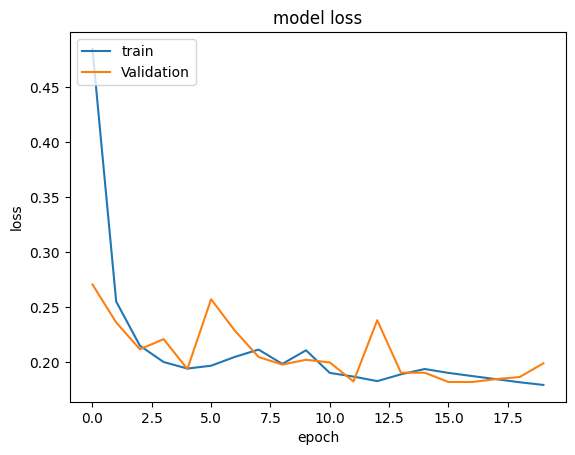

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

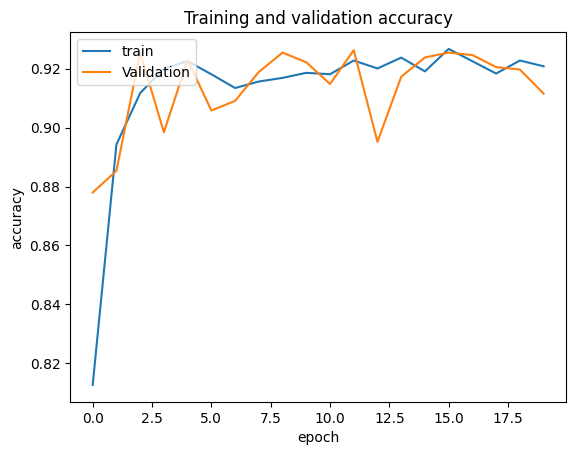

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 4ms/step
0.8794871794871795
0.8800662265045907


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

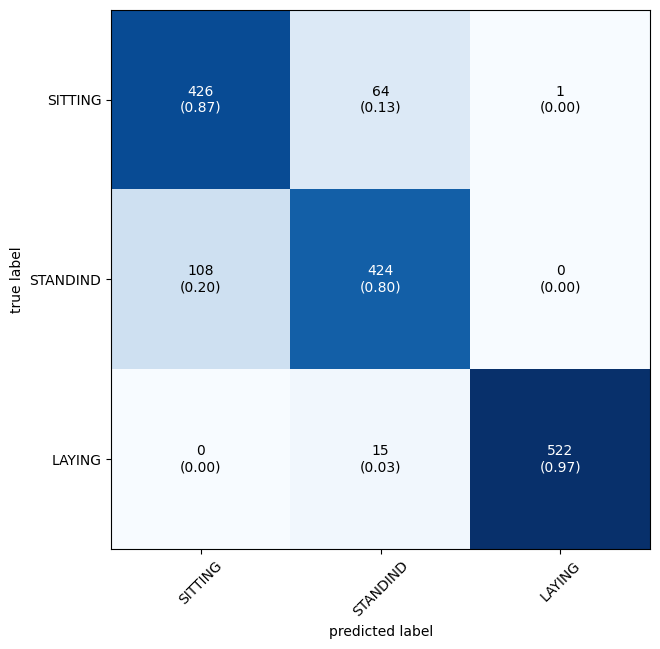

In [40]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# Layer4

# CNN4

In [41]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

# Global Average Pooling to remove the time dimension and keep only features dimension
model.add(GlobalAveragePooling1D())

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_29 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_31 (TimeD  (None, None, 12, 64)     

In [42]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 2s 15ms/step - loss: 0.4279 - accuracy: 0.8227 - val_loss: 0.3167 - val_accuracy: 0.9034
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2194 - accuracy: 0.9029 - val_loss: 0.3652 - val_accuracy: 0.9173
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2004 - accuracy: 0.9112 - val_loss: 0.3434 - val_accuracy: 0.9181
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1928 - accuracy: 0.9164 - val_loss: 0.3350 - val_accuracy: 0.9238
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1904 - accuracy: 0.9203 - val_loss: 0.3423 - val_accuracy: 0.9148
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1817 - accuracy: 0.9211 - val_loss: 0.3198 - val_accuracy: 0.9165
Epoch 7/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1756 - accuracy: 0.9203 - val_loss: 0.2979 - val_accuracy: 0.9140
Epoch 8/20
32/32 [=

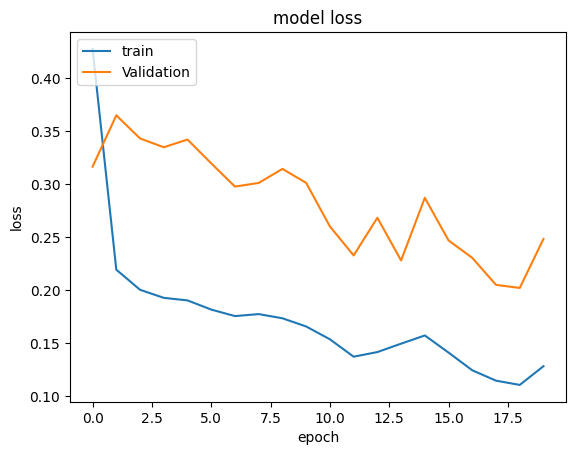

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

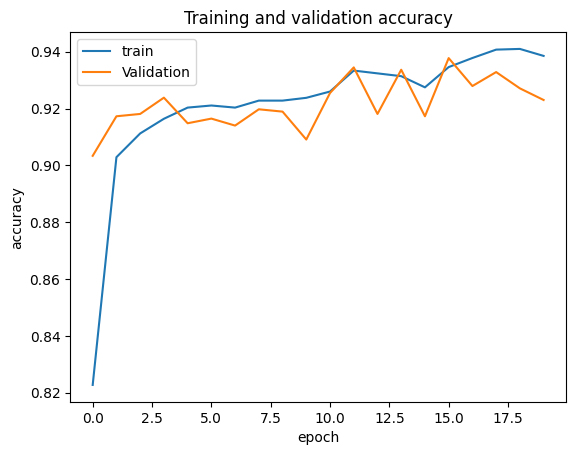

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 1ms/step
0.825
0.8246162089911989


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

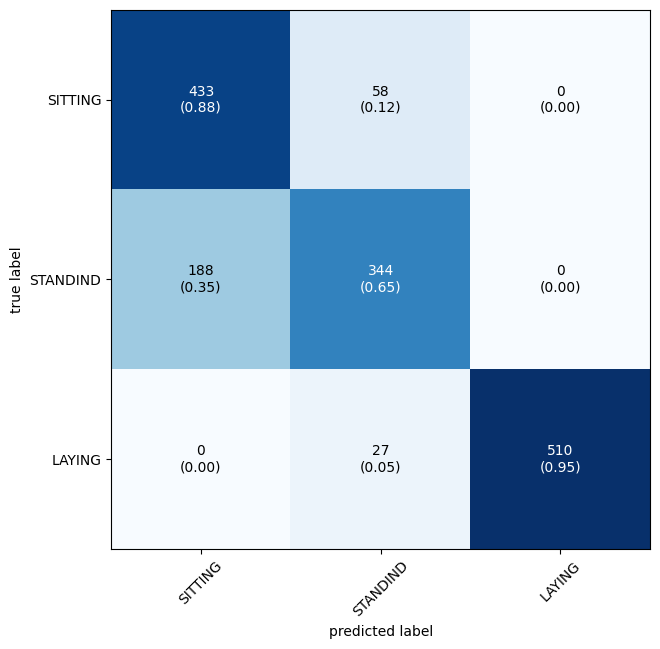

In [45]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN1 - LSTM3

In [46]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_39 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_40 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_41 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_7 (LSTM)               (None, None, 100)        

In [47]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 5s 34ms/step - loss: 0.5668 - accuracy: 0.7389 - val_loss: 0.2754 - val_accuracy: 0.8771
Epoch 2/20
32/32 [==============================] - 0s 9ms/step - loss: 0.2448 - accuracy: 0.9002 - val_loss: 0.2035 - val_accuracy: 0.9206
Epoch 3/20
32/32 [==============================] - 0s 8ms/step - loss: 0.2154 - accuracy: 0.9083 - val_loss: 0.2009 - val_accuracy: 0.9222
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1994 - accuracy: 0.9162 - val_loss: 0.1826 - val_accuracy: 0.9206
Epoch 5/20
32/32 [==============================] - 0s 9ms/step - loss: 0.2034 - accuracy: 0.9132 - val_loss: 0.2135 - val_accuracy: 0.9148
Epoch 6/20
32/32 [==============================] - 1s 23ms/step - loss: 0.2060 - accuracy: 0.9137 - val_loss: 0.1776 - val_accuracy: 0.9189
Epoch 7/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1863 - accuracy: 0.9154 - val_loss: 0.1752 - val_accuracy: 0.9287
Epoch 8/20
32/32 [

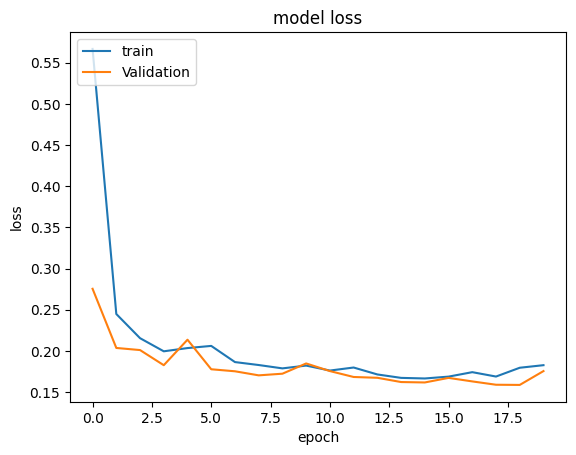

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

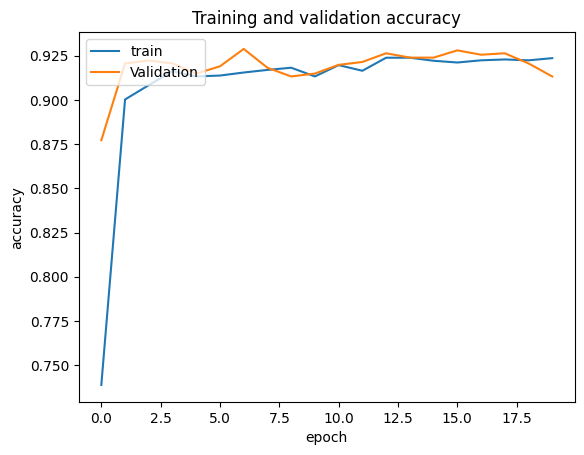

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 2ms/step
0.8717948717948718
0.8725776606941283


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

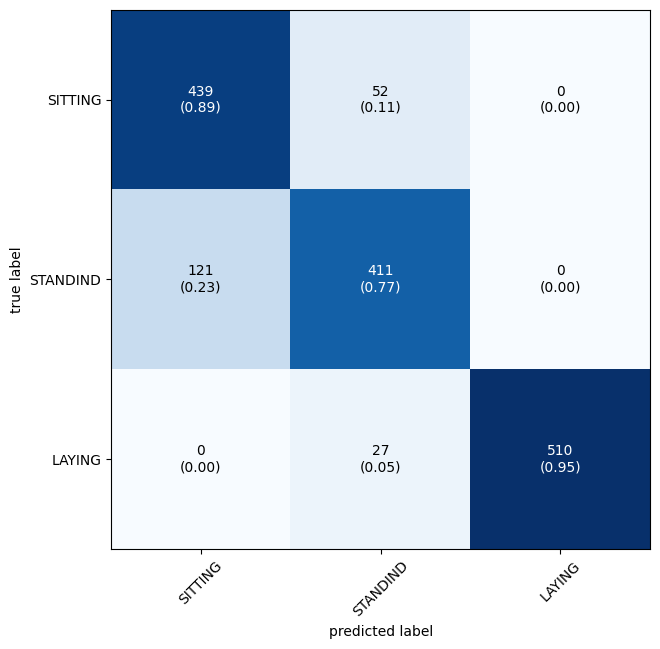

In [50]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN2 - LSTM2

In [51]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_43 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_44 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_45 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_46 (TimeD  (None, None, 896)        

In [52]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 4s 27ms/step - loss: 0.4587 - accuracy: 0.8141 - val_loss: 0.2065 - val_accuracy: 0.9042
Epoch 2/20
32/32 [==============================] - 0s 8ms/step - loss: 0.2154 - accuracy: 0.9134 - val_loss: 0.1960 - val_accuracy: 0.9099
Epoch 3/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1992 - accuracy: 0.9120 - val_loss: 0.1899 - val_accuracy: 0.9214
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1920 - accuracy: 0.9216 - val_loss: 0.1826 - val_accuracy: 0.9206
Epoch 5/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1848 - accuracy: 0.9149 - val_loss: 0.1769 - val_accuracy: 0.9173
Epoch 6/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1766 - accuracy: 0.9218 - val_loss: 0.1704 - val_accuracy: 0.9148
Epoch 7/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1728 - accuracy: 0.9164 - val_loss: 0.1654 - val_accuracy: 0.9173
Epoch 8/20
32/32 [=

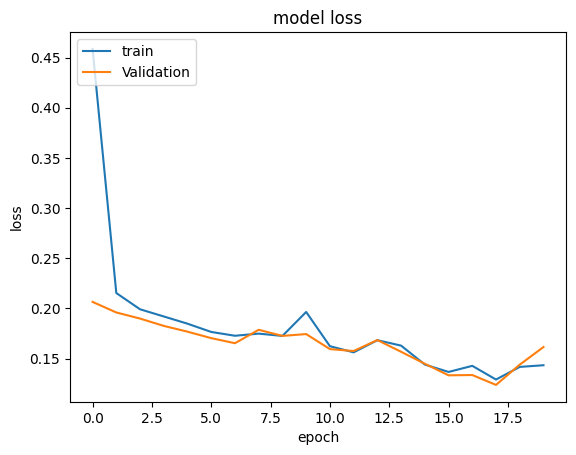

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

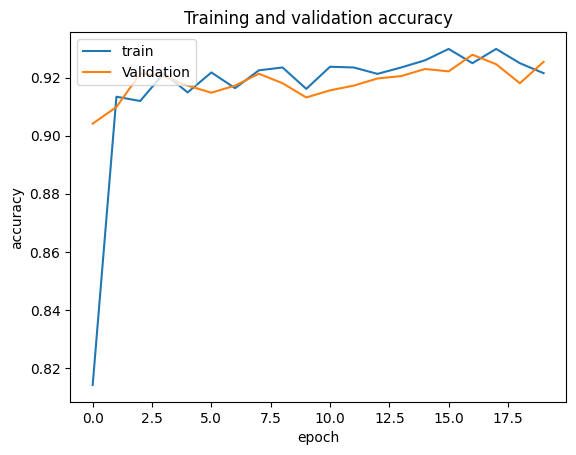

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 2ms/step
0.9012820512820513
0.9005792802571763


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

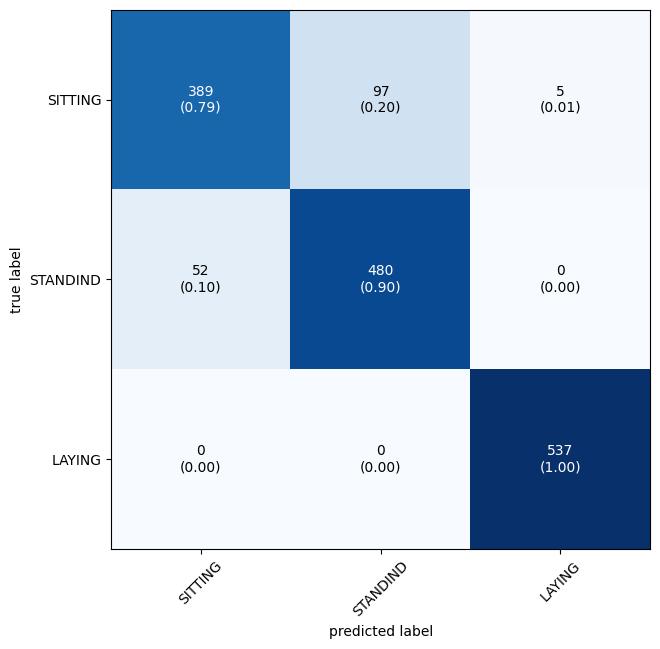

In [55]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN3 - LSTM1

In [56]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_47 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_48 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_49 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_50 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_51 (TimeD  (None, None, 12, 64)     

In [57]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 3s 20ms/step - loss: 0.4375 - accuracy: 0.8161 - val_loss: 0.2402 - val_accuracy: 0.9025
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2211 - accuracy: 0.9058 - val_loss: 0.2377 - val_accuracy: 0.9222
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2015 - accuracy: 0.9176 - val_loss: 0.2450 - val_accuracy: 0.9173
Epoch 4/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2022 - accuracy: 0.9098 - val_loss: 0.2320 - val_accuracy: 0.9238
Epoch 5/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1994 - accuracy: 0.9134 - val_loss: 0.2142 - val_accuracy: 0.9050
Epoch 6/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1854 - accuracy: 0.9162 - val_loss: 0.2112 - val_accuracy: 0.9189
Epoch 7/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1856 - accuracy: 0.9179 - val_loss: 0.2079 - val_accuracy: 0.9050
Epoch 8/20
32/32 [=

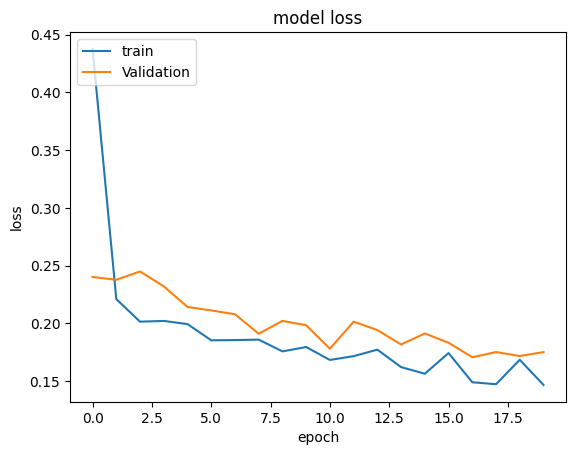

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

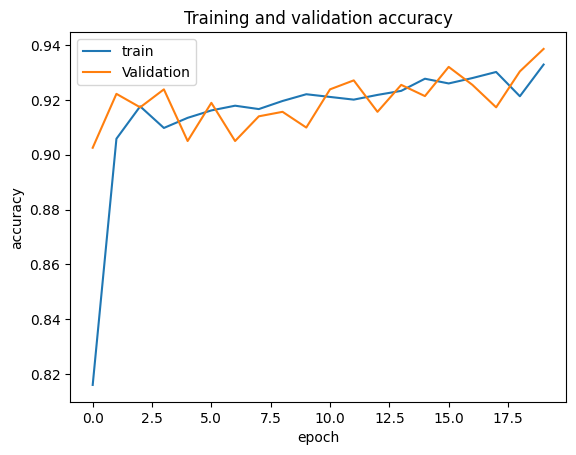

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
0.8826923076923077
0.8838020908231842


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

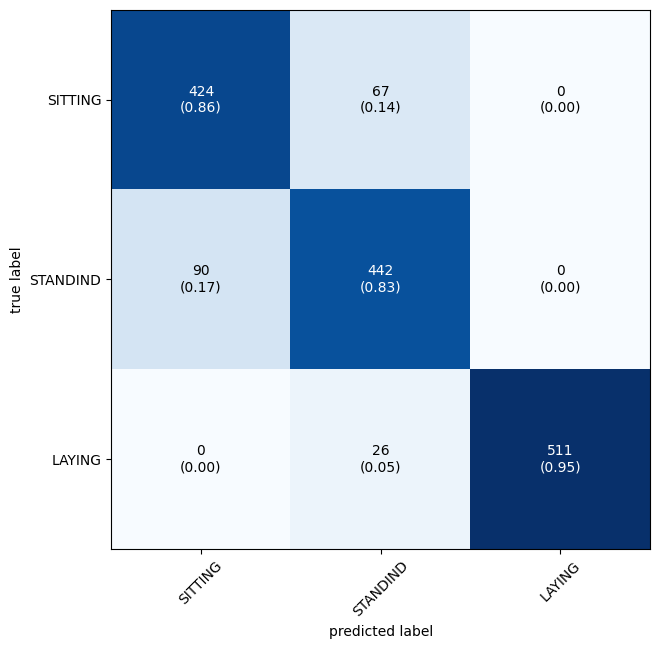

In [60]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# LSTM4

In [61]:
# define model
model = Sequential()
model.add(TimeDistributed(LSTM(100, return_sequences=True), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100)))

# Use TimeDistributed to flatten the LSTM outputs
model.add(TimeDistributed(Flatten()))

# Pool the time dimension
model.add(GlobalAveragePooling1D())

# Adding Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_55 (TimeD  (None, None, 32, 100)     44000     
 istributed)                                                     
                                                                 
 time_distributed_56 (TimeD  (None, None, 32, 100)     0         
 istributed)                                                     
                                                                 
 time_distributed_57 (TimeD  (None, None, 32, 100)     80400     
 istributed)                                                     
                                                                 
 time_distributed_58 (TimeD  (None, None, 32, 100)     0         
 istributed)                                                     
                                                                 
 time_distributed_59 (TimeD  (None, None, 32, 100)    

In [62]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 7s 48ms/step - loss: 0.5065 - accuracy: 0.7917 - val_loss: 0.3198 - val_accuracy: 0.8649
Epoch 2/20
32/32 [==============================] - 0s 15ms/step - loss: 0.2468 - accuracy: 0.9021 - val_loss: 0.2518 - val_accuracy: 0.8829
Epoch 3/20
32/32 [==============================] - 0s 15ms/step - loss: 0.2179 - accuracy: 0.9088 - val_loss: 0.2072 - val_accuracy: 0.9230
Epoch 4/20
32/32 [==============================] - 0s 15ms/step - loss: 0.2305 - accuracy: 0.9154 - val_loss: 0.2487 - val_accuracy: 0.8878
Epoch 5/20
32/32 [==============================] - 0s 15ms/step - loss: 0.2125 - accuracy: 0.9073 - val_loss: 0.2077 - val_accuracy: 0.9091
Epoch 6/20
32/32 [==============================] - 0s 15ms/step - loss: 0.2088 - accuracy: 0.9117 - val_loss: 0.2136 - val_accuracy: 0.8968
Epoch 7/20
32/32 [==============================] - 0s 15ms/step - loss: 0.1975 - accuracy: 0.9221 - val_loss: 0.1981 - val_accuracy: 0.9296
Epoch 8/20
32

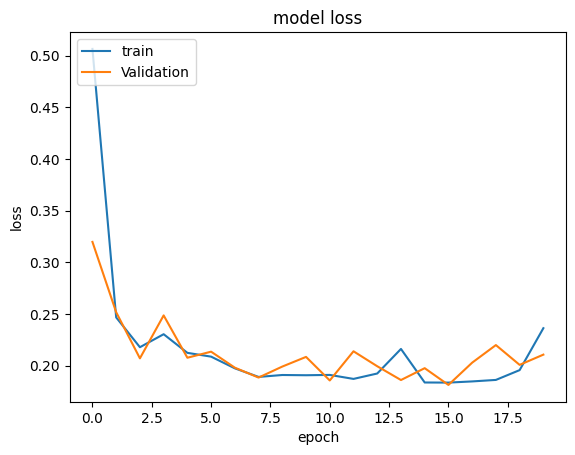

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

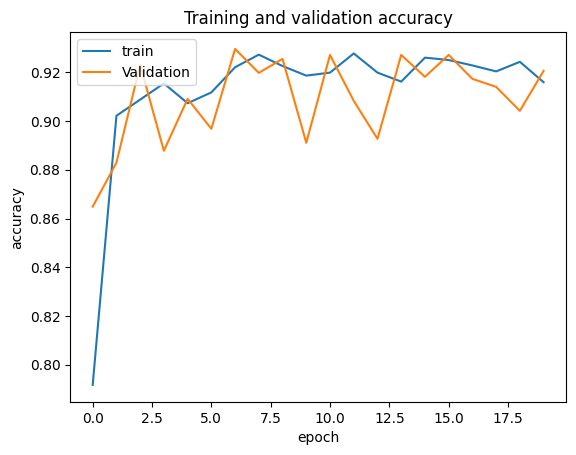

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 5ms/step
0.8846153846153846
0.8846595128012925


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

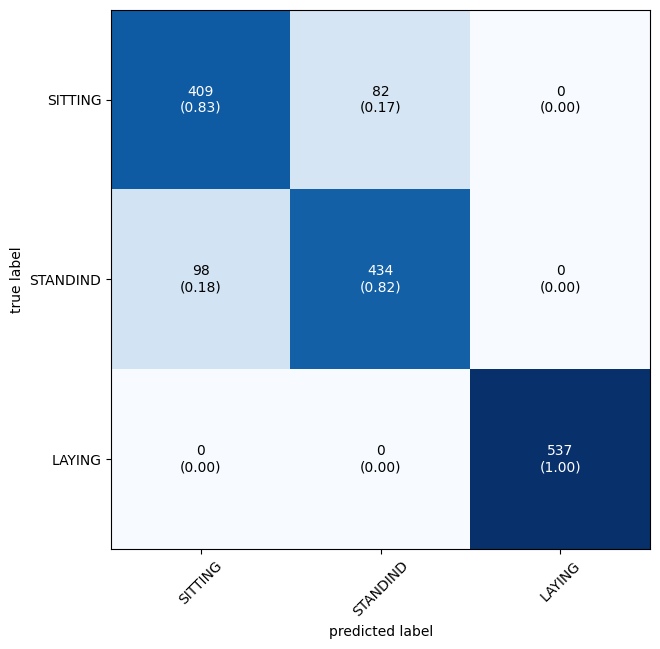

In [65]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# Layer5

# CNN 5

In [72]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

# Global Average Pooling to remove the time dimension and keep only features dimension
model.add(GlobalAveragePooling1D())

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_138 (Time  (None, None, 32, 64)      1792      
 Distributed)                                                    
                                                                 
 time_distributed_139 (Time  (None, None, 32, 64)      12352     
 Distributed)                                                    
                                                                 
 time_distributed_140 (Time  (None, None, 32, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_141 (Time  (None, None, 16, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_142 (Time  (None, None, 16, 64)    

In [73]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 3s 25ms/step - loss: 0.4032 - accuracy: 0.8333 - val_loss: 0.4611 - val_accuracy: 0.8952
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2157 - accuracy: 0.9088 - val_loss: 0.4322 - val_accuracy: 0.8886
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2032 - accuracy: 0.9154 - val_loss: 0.4373 - val_accuracy: 0.9230
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1969 - accuracy: 0.9169 - val_loss: 0.4167 - val_accuracy: 0.9091
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1997 - accuracy: 0.9127 - val_loss: 0.3963 - val_accuracy: 0.9156
Epoch 6/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1939 - accuracy: 0.9191 - val_loss: 0.4172 - val_accuracy: 0.9132
Epoch 7/20
32/32 [==============================] - 0s 6ms/step - loss: 0.1938 - accuracy: 0.9181 - val_loss: 0.4112 - val_accuracy: 0.9173
Epoch 8/20
32/32 [=

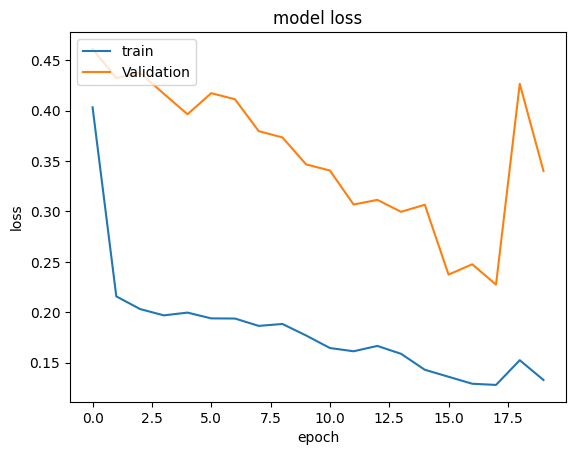

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

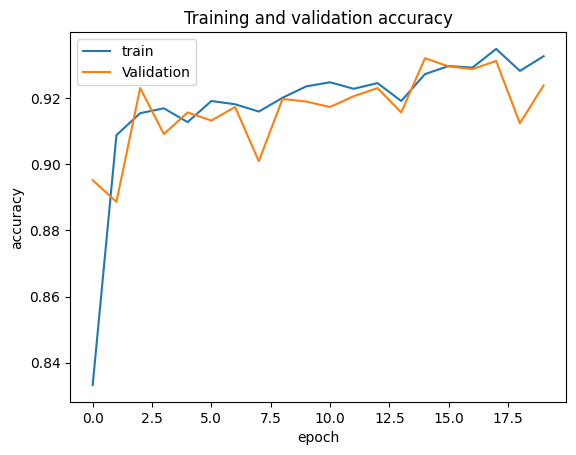

In [75]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
0.8487179487179487
0.8493760525046862


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

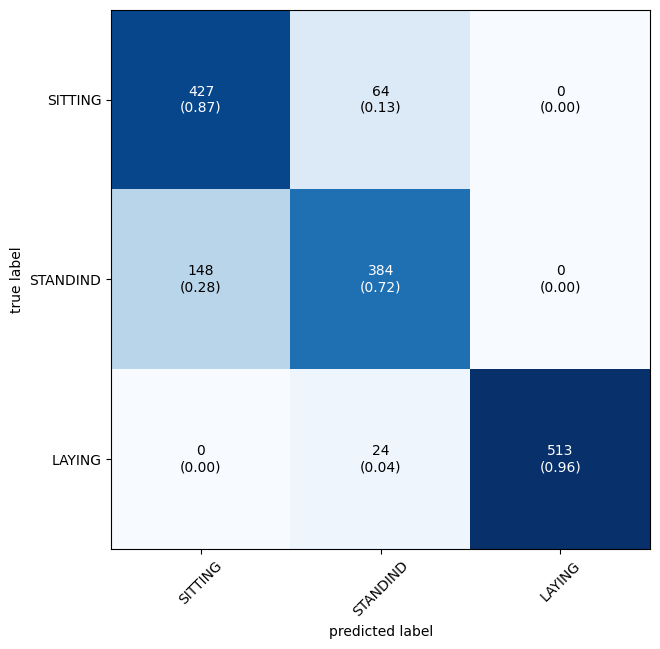

In [76]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# C4 L1

In [77]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_152 (Time  (None, None, 30, 64)      1792      
 Distributed)                                                    
                                                                 
 time_distributed_153 (Time  (None, None, 28, 64)      12352     
 Distributed)                                                    
                                                                 
 time_distributed_154 (Time  (None, None, 28, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_155 (Time  (None, None, 14, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_156 (Time  (None, None, 12, 64)    

In [78]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 4s 23ms/step - loss: 0.4737 - accuracy: 0.7890 - val_loss: 0.3000 - val_accuracy: 0.8518
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2276 - accuracy: 0.9026 - val_loss: 0.2498 - val_accuracy: 0.8870
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 0.2167 - accuracy: 0.9112 - val_loss: 0.2613 - val_accuracy: 0.8796
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.2054 - accuracy: 0.9139 - val_loss: 0.2172 - val_accuracy: 0.9083
Epoch 5/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1934 - accuracy: 0.9142 - val_loss: 0.1977 - val_accuracy: 0.9206
Epoch 6/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1780 - accuracy: 0.9223 - val_loss: 0.1892 - val_accuracy: 0.9206
Epoch 7/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1996 - accuracy: 0.9169 - val_loss: 0.1853 - val_accuracy: 0.9132
Epoch 8/20
32/32 [=

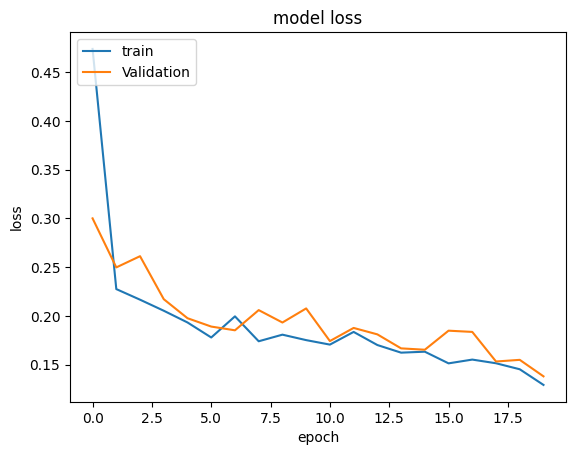

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

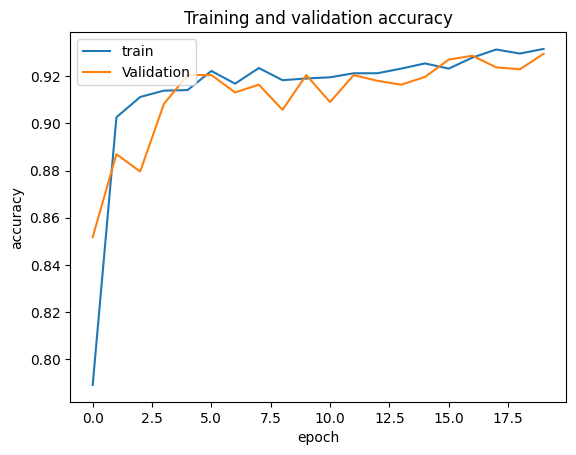

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
0.8794871794871795
0.8807236313908803


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

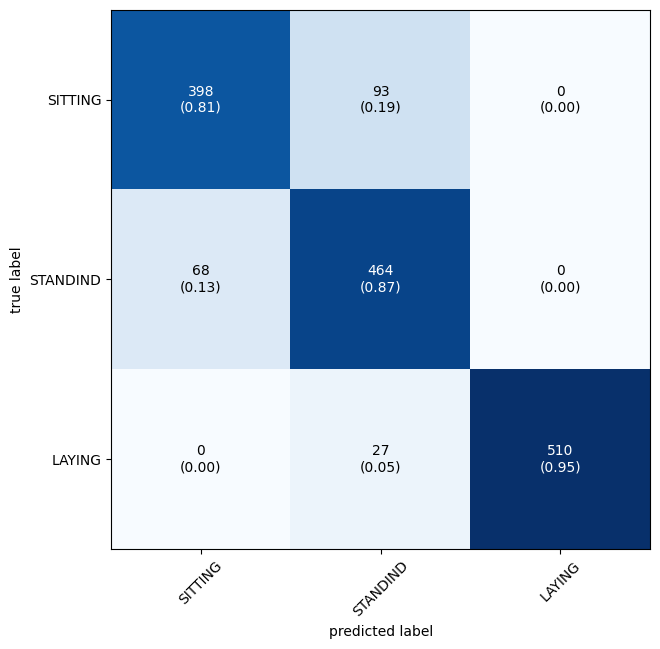

In [81]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN3 - LSTM2

In [82]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_161 (Time  (None, None, 30, 64)      1792      
 Distributed)                                                    
                                                                 
 time_distributed_162 (Time  (None, None, 28, 64)      12352     
 Distributed)                                                    
                                                                 
 time_distributed_163 (Time  (None, None, 28, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_164 (Time  (None, None, 14, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_165 (Time  (None, None, 12, 64)    

In [83]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 4s 28ms/step - loss: 0.5339 - accuracy: 0.7482 - val_loss: 0.2518 - val_accuracy: 0.9025
Epoch 2/20
32/32 [==============================] - 0s 9ms/step - loss: 0.2336 - accuracy: 0.9026 - val_loss: 0.2316 - val_accuracy: 0.9189
Epoch 3/20
32/32 [==============================] - 0s 8ms/step - loss: 0.2140 - accuracy: 0.9036 - val_loss: 0.2120 - val_accuracy: 0.9042
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1999 - accuracy: 0.9120 - val_loss: 0.2064 - val_accuracy: 0.9197
Epoch 5/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1927 - accuracy: 0.9218 - val_loss: 0.2252 - val_accuracy: 0.9189
Epoch 6/20
32/32 [==============================] - 0s 9ms/step - loss: 0.1856 - accuracy: 0.9194 - val_loss: 0.1885 - val_accuracy: 0.9165
Epoch 7/20
32/32 [==============================] - 0s 9ms/step - loss: 0.1924 - accuracy: 0.9174 - val_loss: 0.1857 - val_accuracy: 0.9140
Epoch 8/20
32/32 [=

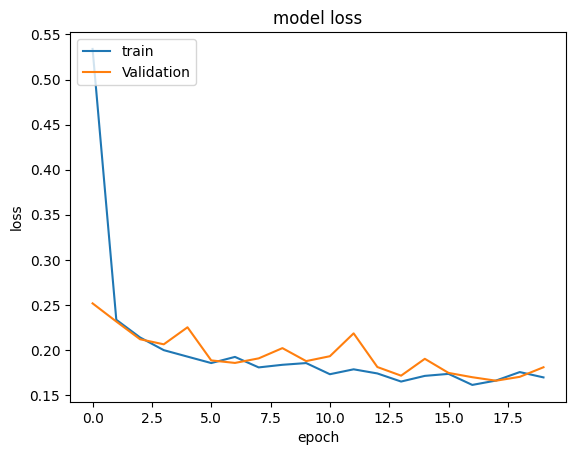

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

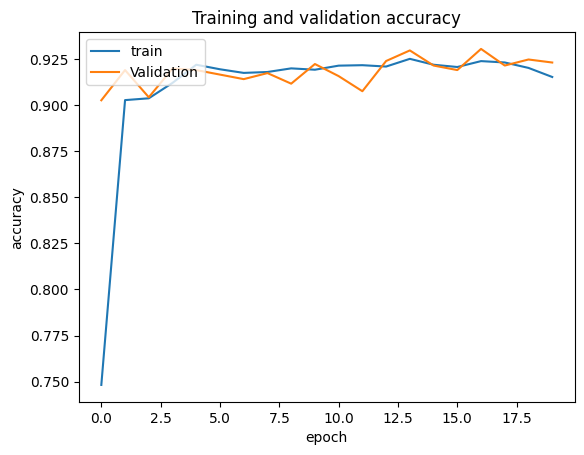

In [85]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 2ms/step
0.8762820512820513
0.876807524218531


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

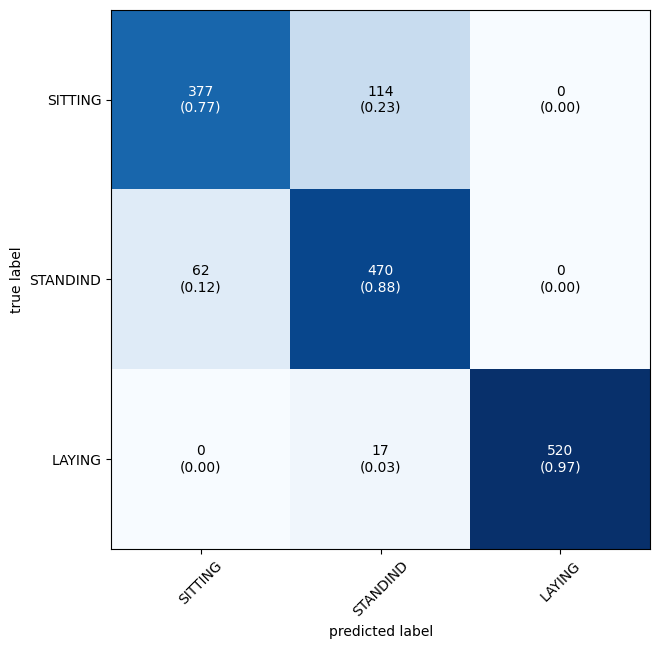

In [86]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN2-LSTM3

In [87]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))




model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_169 (Time  (None, None, 30, 64)      1792      
 Distributed)                                                    
                                                                 
 time_distributed_170 (Time  (None, None, 28, 64)      12352     
 Distributed)                                                    
                                                                 
 time_distributed_171 (Time  (None, None, 28, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_172 (Time  (None, None, 14, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_173 (Time  (None, None, 896)       

In [88]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 5s 35ms/step - loss: 0.5608 - accuracy: 0.7755 - val_loss: 0.2716 - val_accuracy: 0.8739
Epoch 2/20
32/32 [==============================] - 0s 9ms/step - loss: 0.2326 - accuracy: 0.9039 - val_loss: 0.1993 - val_accuracy: 0.9189
Epoch 3/20
32/32 [==============================] - 0s 9ms/step - loss: 0.2089 - accuracy: 0.9105 - val_loss: 0.2391 - val_accuracy: 0.8870
Epoch 4/20
32/32 [==============================] - 0s 9ms/step - loss: 0.2108 - accuracy: 0.9115 - val_loss: 0.1892 - val_accuracy: 0.9181
Epoch 5/20
32/32 [==============================] - 0s 9ms/step - loss: 0.1910 - accuracy: 0.9164 - val_loss: 0.1900 - val_accuracy: 0.9263
Epoch 6/20
32/32 [==============================] - 0s 9ms/step - loss: 0.1825 - accuracy: 0.9206 - val_loss: 0.1790 - val_accuracy: 0.9247
Epoch 7/20
32/32 [==============================] - 0s 9ms/step - loss: 0.1824 - accuracy: 0.9223 - val_loss: 0.1779 - val_accuracy: 0.9206
Epoch 8/20
32/32 [=

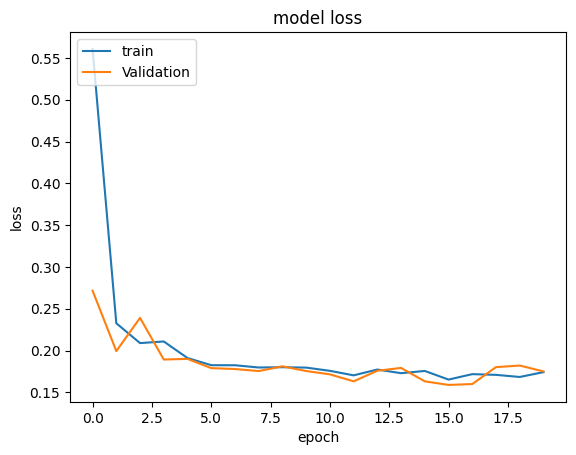

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

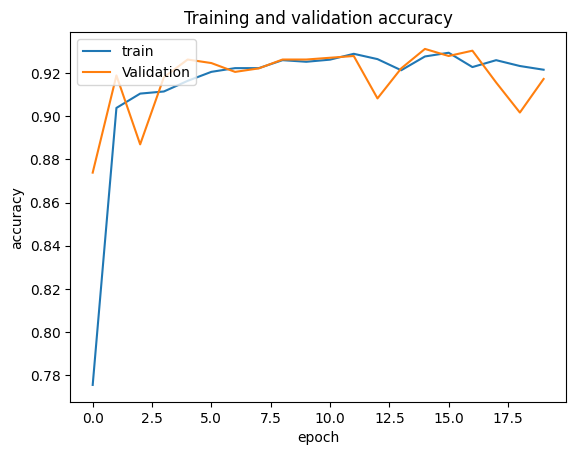

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 2ms/step
0.8628205128205129
0.8637801682585143


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

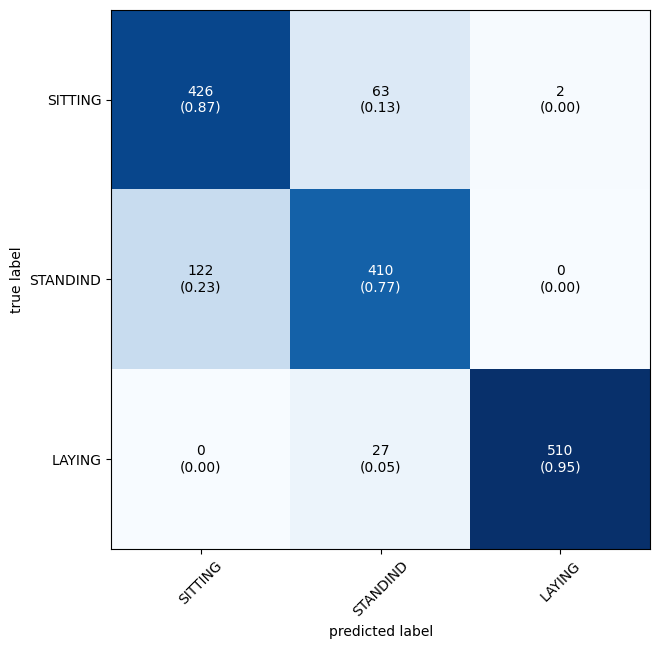

In [91]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# CNN1 - LSTM4

In [92]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_174 (Time  (None, None, 30, 64)      1792      
 Distributed)                                                    
                                                                 
 time_distributed_175 (Time  (None, None, 30, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_176 (Time  (None, None, 15, 64)      0         
 Distributed)                                                    
                                                                 
 time_distributed_177 (Time  (None, None, 960)         0         
 Distributed)                                                    
                                                                 
 lstm_23 (LSTM)              (None, None, 100)       

In [93]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 6s 42ms/step - loss: 0.6888 - accuracy: 0.6508 - val_loss: 0.4600 - val_accuracy: 0.6708
Epoch 2/20
32/32 [==============================] - 0s 10ms/step - loss: 0.3785 - accuracy: 0.8028 - val_loss: 0.2713 - val_accuracy: 0.8976
Epoch 3/20
32/32 [==============================] - 1s 18ms/step - loss: 0.2672 - accuracy: 0.8967 - val_loss: 0.2091 - val_accuracy: 0.9181
Epoch 4/20
32/32 [==============================] - 0s 11ms/step - loss: 0.2167 - accuracy: 0.9132 - val_loss: 0.2234 - val_accuracy: 0.9165
Epoch 5/20
32/32 [==============================] - 0s 11ms/step - loss: 0.2058 - accuracy: 0.9098 - val_loss: 0.1879 - val_accuracy: 0.9222
Epoch 6/20
32/32 [==============================] - 0s 10ms/step - loss: 0.2028 - accuracy: 0.9147 - val_loss: 0.2154 - val_accuracy: 0.9255
Epoch 7/20
32/32 [==============================] - 0s 10ms/step - loss: 0.1931 - accuracy: 0.9147 - val_loss: 0.1963 - val_accuracy: 0.8984
Epoch 8/20
32

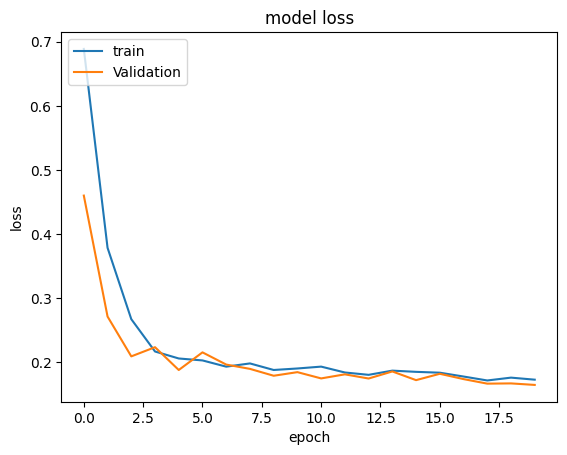

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

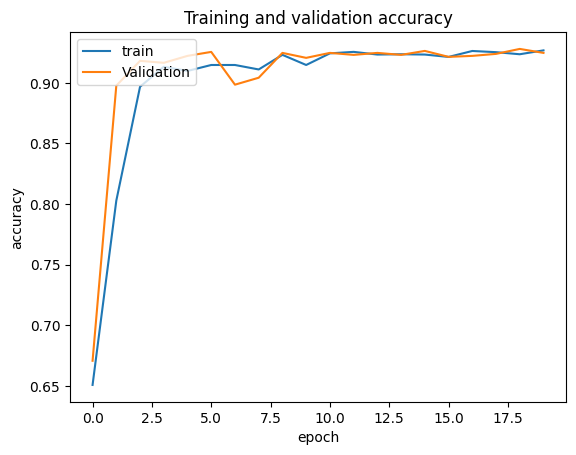

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
0.8576923076923076
0.8592267704602856


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

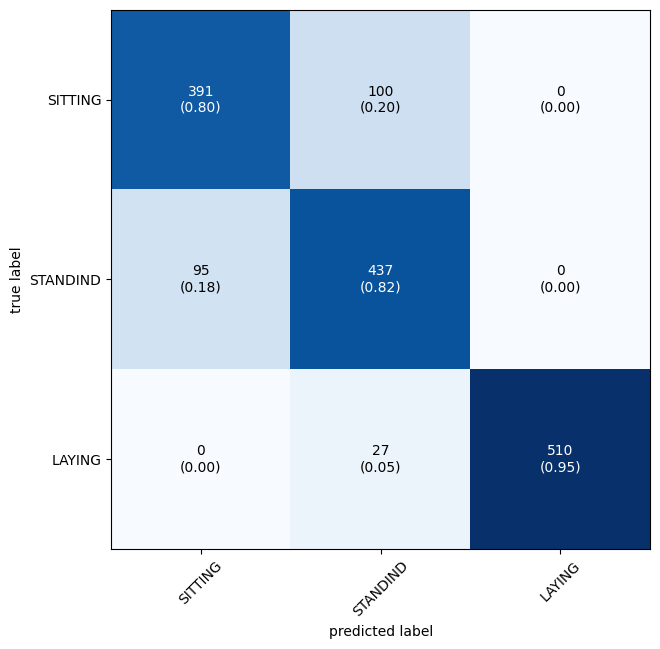

In [96]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# LSTM 5

In [97]:
# define model
model = Sequential()
model.add(TimeDistributed(LSTM(100, return_sequences=True), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(LSTM(100)))

# Use TimeDistributed to flatten the LSTM outputs
model.add(TimeDistributed(Flatten()))

# Pool the time dimension
model.add(GlobalAveragePooling1D())

# Adding Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_178 (Time  (None, None, 32, 100)     44000     
 Distributed)                                                    
                                                                 
 time_distributed_179 (Time  (None, None, 32, 100)     0         
 Distributed)                                                    
                                                                 
 time_distributed_180 (Time  (None, None, 32, 100)     80400     
 Distributed)                                                    
                                                                 
 time_distributed_181 (Time  (None, None, 32, 100)     0         
 Distributed)                                                    
                                                                 
 time_distributed_182 (Time  (None, None, 32, 100)   

In [98]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/20
32/32 [==============================] - 7s 58ms/step - loss: 0.5658 - accuracy: 0.7251 - val_loss: 0.4490 - val_accuracy: 0.7977
Epoch 2/20
32/32 [==============================] - 1s 17ms/step - loss: 0.2944 - accuracy: 0.8719 - val_loss: 0.2655 - val_accuracy: 0.8853
Epoch 3/20
32/32 [==============================] - 1s 17ms/step - loss: 0.2351 - accuracy: 0.8994 - val_loss: 0.2485 - val_accuracy: 0.8943
Epoch 4/20
32/32 [==============================] - 1s 17ms/step - loss: 0.2200 - accuracy: 0.9093 - val_loss: 0.2121 - val_accuracy: 0.8952
Epoch 5/20
32/32 [==============================] - 1s 18ms/step - loss: 0.2006 - accuracy: 0.9186 - val_loss: 0.1950 - val_accuracy: 0.9287
Epoch 6/20
32/32 [==============================] - 1s 18ms/step - loss: 0.1908 - accuracy: 0.9240 - val_loss: 0.1889 - val_accuracy: 0.9271
Epoch 7/20
32/32 [==============================] - 1s 17ms/step - loss: 0.1937 - accuracy: 0.9196 - val_loss: 0.2069 - val_accuracy: 0.9197
Epoch 8/20
32

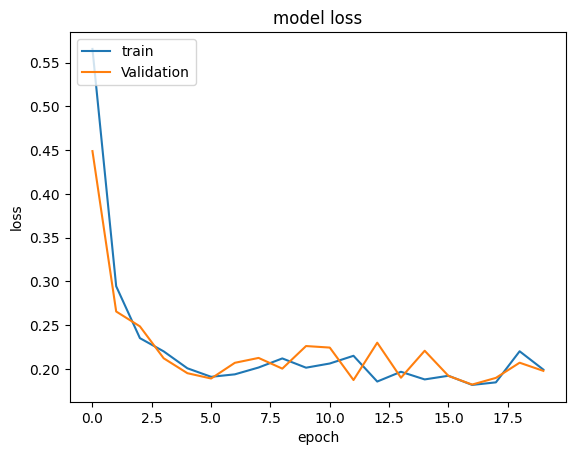

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

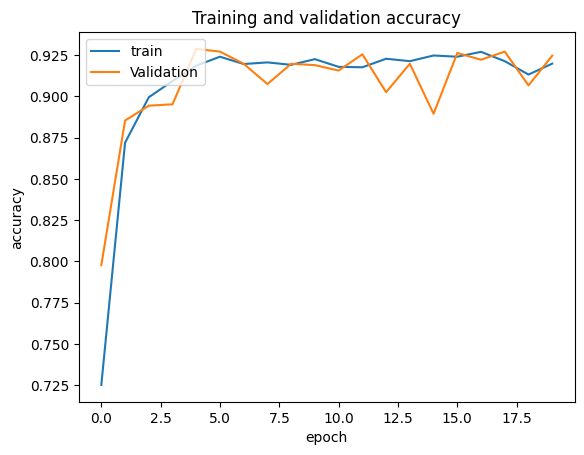

In [100]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 6ms/step
0.8602564102564103
0.8617609853673408


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

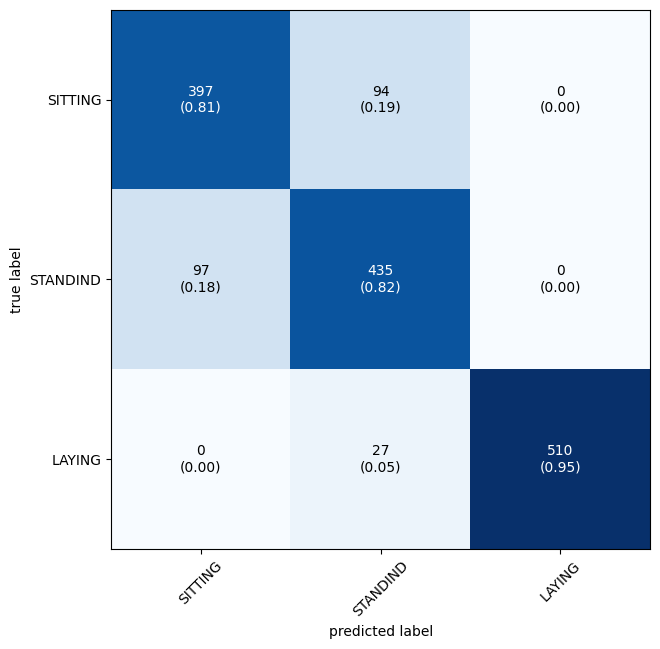

In [101]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))